In [1]:
%cd Dragonfly/

/teamspace/studios/this_studio/Dragonfly


In [2]:
# Import necessary libraries
import torch
from PIL import Image
from transformers import AutoProcessor, AutoTokenizer

from src.dragonfly.models.modeling_dragonfly import DragonflyForCausalLM
from src.dragonfly.models.processing_dragonfly import DragonflyProcessor
from pipeline.train.train_utils import random_seed

In [3]:
# Set device to GPU
device = torch.device("cuda:0")

# Load the model, tokenizer, and processor
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/Llama-3.1-8B-Dragonfly-Med-v2")
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
image_processor = clip_processor.image_processor
processor = DragonflyProcessor(image_processor=image_processor, tokenizer=tokenizer, image_encoding_style="llava-hd")

model = DragonflyForCausalLM.from_pretrained("togethercomputer/Llama-3.1-8B-Dragonfly-Med-v2")
model = model.to(torch.bfloat16)
model = model.to(device)

DragonflyForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Initialize Vision Encoder


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

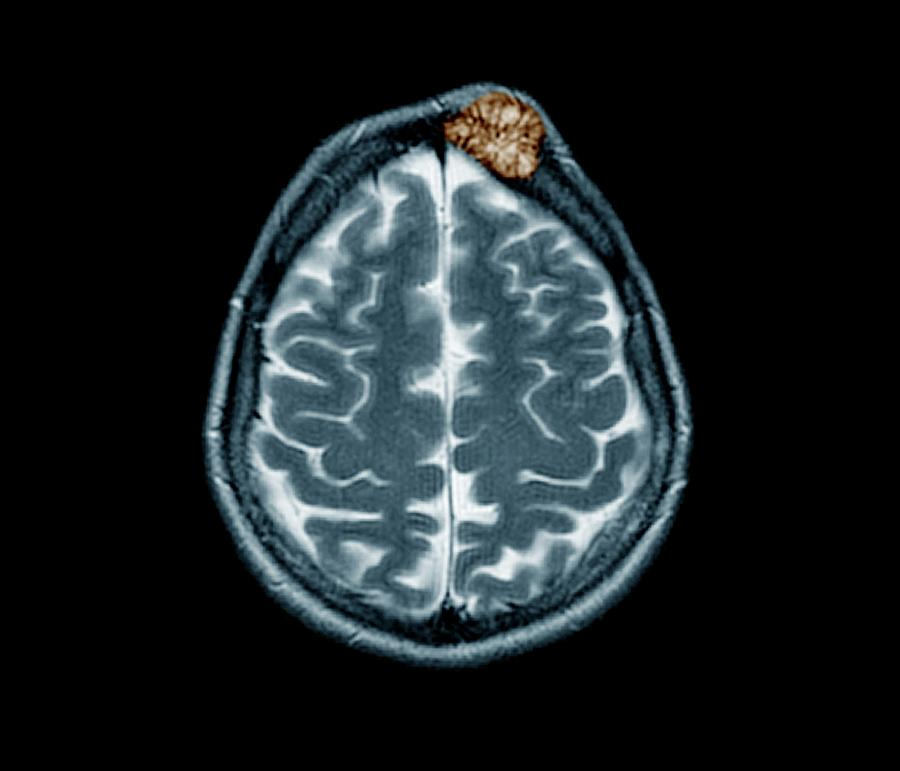

In [8]:
from PIL import Image
import requests
from io import BytesIO

# URL of the image
url = "https://raw.githubusercontent.com/sitamgithub-MSIT/test/main/assets/brain-tumor.jpg"

# Fetch the image from the URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))  # Open the image from the byte content
img = img.convert("RGB")

# Put the image in a list
images = [img]
# images = [None] # if you do not want to pass any images

# Show the image
img.show()

In [9]:
# The actual question as a variable
actual_question = "What diseases are included in the picture?"

# Inserting the question into the text_prompt
text_prompt = f"<|start_header_id|>user<|end_header_id|>\n\n{actual_question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

# Preprocess the input
inputs = processor(
    text=[text_prompt],
    images=images,
    max_length=1024,
    return_tensors="pt",
    is_generate=True,
)
inputs = inputs.to(device)

In [10]:
# Set temperature and max output length for generation
temperature = 0.2
max_new_tokens = 1024

# Generate text using the inference mode
with torch.inference_mode():
    generation_output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.encode("<|eot_id|>"),
        do_sample=temperature > 0,
        temperature=temperature,
        use_cache=True
    )

# Get the generated text
generation_text = processor.batch_decode(generation_output, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


In [11]:
# Access the first element of the list
output_text = generation_text[0]

# Extracting the assistant's response
if "assistant\n\n" in output_text:
    assistant_response = output_text.split("assistant\n\n", 1)[1].strip()
else:
    assistant_response = output_text.strip()  # Fallback if "assistant" marker is missing

# Return the assistant response
print(f"Assistant Response: {assistant_response}")

Assistant Response: Brain Edema, Brain Enhancing Tumor
